# Quick CNN Training - Ultra Lightweight + Augmentation

## Overview
This notebook contains only the essential components for training the ultra-lightweight CNN with augmentation and random shuffle split.

## Features
- **7 Core Concepts**: periodicity, temporal_stability, coordination, motion_intensity, vertical_dominance, directional_variability, burstiness
- **Data Augmentation**: Jitter, scaling, and rotation for robust training
- **Contextual Learning**: Static posture context for motion concepts
- **Optimized Architecture**: Lightweight CNN with enhanced parameters for 7 concepts


## 1. Imports and Configuration

**Purpose**: Load necessary libraries and contextual configuration for model training.

**Key Components**:
- TensorFlow/Keras for deep learning
- Scikit-learn for data preprocessing
- Contextual configuration for motion concepts


# Quick CNN Training - Ultra Lightweight + Augmentation
## Streamlined version for rapid iteration

This notebook contains only the essential components for training the ultra-lightweight CNN with augmentation and random shuffle split.

In [2910]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import warnings
import json
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Load contextual configuration from rule definitions
try:
    with open('../rule_based_labeling/contextual_config.json', 'r') as f:
        contextual_config = json.load(f)
    print(f"\nLoaded contextual configuration:")
    for feature, uses_context in contextual_config.items():
        print(f"  {feature}: {'Uses static posture context' if uses_context else 'Independent'}")
except FileNotFoundError:
    print("Warning: contextual_config.json not found. Using default configuration.")
    contextual_config = {
        'motion_intensity': True,
        'vertical_dominance': True,
        'periodicity': False,
        'temporal_stability': False,
        'coordination': False
    }

TensorFlow version: 2.20.0
Keras version: 3.11.3

Loaded contextual configuration:
  motion_intensity: Uses static posture context
  vertical_dominance: Uses static posture context
  periodicity: Independent
  temporal_stability: Independent
  coordination: Independent
  directional_variability: Independent
  burstiness: Independent


## 2. Data Loading and Discretization

**Purpose**: Load sensor data and convert continuous concept values to discrete categories.

**Process**:
- Load raw sensor data and window labels
- Convert continuous values to discrete (0.0, 0.5, 1.0) for all concepts
- Apply discretization rules for motion_intensity and vertical_dominance


In [2911]:
# Load data - CHANGE THESE PATHS AS NEEDED
df_sensor = pd.read_csv('../rule_based_labeling/raw_with_features.csv')
df_windows = pd.read_csv('../rule_based_labeling/window_with_features.csv') 

print(f"Sensor data: {len(df_sensor)} readings")
print(f"Manual labels: {len(df_windows)} windows")
print(f"\nLabeled windows:")
print(df_windows.head())

# Check available concepts
concept_columns = ['periodicity', 'temporal_stability', 'coordination', 'motion_intensity', 'vertical_dominance', 'static_posture', 'directional_variability', 'burstiness']
print(f"\nAvailable concepts: {concept_columns}")

# Debug: Check original values BEFORE discretization
print(f"\n=== BEFORE DISCRETIZATION ===")
print(f"Original motion_intensity range: {df_windows['motion_intensity'].min():.4f} to {df_windows['motion_intensity'].max():.4f}")
print(f"Original vertical_dominance range: {df_windows['vertical_dominance'].min():.4f} to {df_windows['vertical_dominance'].max():.4f}")
print(f"Original directional_variability range: {df_windows['directional_variability'].min():.4f} to {df_windows['directional_variability'].max():.4f}")
print(f"Original burstiness range: {df_windows['burstiness'].min():.4f} to {df_windows['burstiness'].max():.4f}")

# Convert rule-based concepts to discrete labels (0, 0.5, 1.0)
print(f"\n=== APPLYING DISCRETIZATION ===")

# Motion Intensity: Convert continuous values to discrete
# Low (0.0): < 0.35, Medium (0.5): 0.35-0.45, High (1.0): > 0.45
df_windows['motion_intensity'] = pd.cut(
    df_windows['motion_intensity'], 
    bins=[-np.inf, 0.35, 0.45, np.inf], 
    labels=[0.0, 0.5, 1.0]
).astype(float)

# Vertical Dominance: Convert continuous values to discrete  
# Low (0.0): < 0.2, Medium (0.5): 0.2-0.35, High (1.0): > 0.35
df_windows['vertical_dominance'] = pd.cut(
    df_windows['vertical_dominance'], 
    bins=[-np.inf, 0.2, 0.35, np.inf], 
    labels=[0.0, 0.5, 1.0]
).astype(float)

# Static Posture: Already binary (0.0 or 1.0), keep as is
# No change needed for static_posture

# Directional Variability: Convert continuous values to discrete
# Low (0.0): < 0.1, Medium (0.5): 0.1-0.2, High (1.0): > 0.2
df_windows['directional_variability'] = pd.cut(
    df_windows['directional_variability'], 
    bins=[-np.inf, 0.1, 0.2, np.inf], 
    labels=[0.0, 0.5, 1.0]
).astype(float)

# Burstiness: Convert continuous values to discrete
# Low (0.0): < 0.15, Medium (0.5): 0.15-0.25, High (1.0): > 0.25
df_windows['burstiness'] = pd.cut(
    df_windows['burstiness'], 
    bins=[-np.inf, 0.15, 0.25, np.inf], 
    labels=[0.0, 0.5, 1.0]
).astype(float)

# Debug: Check discretized values
print(f"\n=== AFTER DISCRETIZATION ===")
print(f"Discretized motion_intensity: {df_windows['motion_intensity'].value_counts().sort_index()}")
print(f"Discretized vertical_dominance: {df_windows['vertical_dominance'].value_counts().sort_index()}")
print(f"Discretized directional_variability: {df_windows['directional_variability'].value_counts().sort_index()}")
print(f"Discretized burstiness: {df_windows['burstiness'].value_counts().sort_index()}")

# Final check: Show all concept distributions
print(f"\n=== FINAL CONCEPT DISTRIBUTIONS ===")
for concept in concept_columns:
    if concept in df_windows.columns:
        values = df_windows[concept].value_counts().sort_index()
        print(f"  {concept}: {dict(values)}")

print(f"\nDiscretization completed successfully!")

Sensor data: 8802 readings
Manual labels: 150 windows

Labeled windows:
   window_idx  user activity  start_time  end_time  periodicity  \
0           0     3  Walking      957.75    960.75          1.0   
1           1     3  Walking       42.00     45.00          1.0   
2           2     3  Walking      871.50    874.50          0.5   
3           3     3  Walking       63.00     66.00          1.0   
4           4     3  Jogging      117.75    120.75          1.0   

   temporal_stability  coordination  motion_intensity  vertical_dominance  \
0                 0.5           0.5          0.316815            0.221105   
1                 0.5           0.5          0.302850            0.291116   
2                 0.5           0.5          0.303036            0.181147   
3                 0.5           0.5          0.313779            0.305797   
4                 0.5           0.5          0.408648            0.262989   

   static_posture  directional_variability  burstiness  
0    

## 3. Window Extraction Functions

**Purpose**: Extract sensor data windows with robust time matching and error handling.

**Functions**:
- `extract_window_robust()`: Extract single window with time tolerance
- `extract_windows_robust()`: Extract all windows for 7 concepts
- Handles missing data and time mismatches gracefully


In [2912]:
def extract_window_robust(df_sensor, window_row, time_tolerance=0.5):
    """
    Extract sensor data with time tolerance to handle mismatches.
    """
    user = window_row['user']
    activity = window_row['activity']
    start_time = window_row['start_time']
    end_time = window_row['end_time']
    
    # Get data for this user/activity
    user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                  (df_sensor['activity'] == activity)].copy()
    
    if len(user_activity_data) == 0:
        return None
    
    # Find data within time window with tolerance
    mask = ((user_activity_data['time_s'] >= start_time - time_tolerance) & 
            (user_activity_data['time_s'] <= end_time + time_tolerance))
    
    window_data = user_activity_data[mask]
    
    if len(window_data) < 10:  # Need minimum samples
        return None
    
    # Extract sensor readings
    sensor_data = window_data[['x-axis', 'y-axis', 'z-axis']].values
    
    # Pad or truncate to fixed length (e.g., 100 samples)
    target_length = 100
    if len(sensor_data) > target_length:
        # Randomly sample if too long
        indices = np.random.choice(len(sensor_data), target_length, replace=False)
        sensor_data = sensor_data[indices]
    elif len(sensor_data) < target_length:
        # Pad with last value if too short
        padding = np.tile(sensor_data[-1:], (target_length - len(sensor_data), 1))
        sensor_data = np.vstack([sensor_data, padding])
    
    return sensor_data

def extract_windows_robust(df_sensor, df_windows):
    """
    Extract all windows with robust time matching for 7 concepts.
    """
    X = []
    y_p = []  # periodicity
    y_t = []  # temporal_stability
    y_c = []  # coordination
    y_mi = [] # motion_intensity
    y_vd = [] # vertical_dominance
    y_sp = [] # static_posture
    y_dv = [] # directional_variability
    y_b = []  # burstiness
    
    for _, window_row in df_windows.iterrows():
        window_data = extract_window_robust(df_sensor, window_row)
        if window_data is not None:
            X.append(window_data)
            y_p.append(window_row['periodicity'])
            y_t.append(window_row['temporal_stability'])
            y_c.append(window_row['coordination'])
            y_mi.append(window_row['motion_intensity'])
            y_vd.append(window_row['vertical_dominance'])
            y_sp.append(window_row['static_posture'])
            y_dv.append(window_row['directional_variability'])
            y_b.append(window_row['burstiness'])
    
    return np.array(X), np.array(y_p), np.array(y_t), np.array(y_c), np.array(y_mi), np.array(y_vd), np.array(y_sp), np.array(y_dv), np.array(y_b)

## 4. Data Augmentation Functions

**Purpose**: Create augmented versions of the dataset to improve model robustness.

**Augmentation Types**:
- **Jitter**: Add Gaussian noise to simulate sensor imperfections
- **Scaling**: Scale magnitude to simulate different movement intensities  
- **Rotation**: Rotate 3D data to simulate different phone orientations
- **Factor**: 10x augmentation multiplier for robust training


In [2913]:
def augment_jitter(data, sigma=0.05):
    """Add random Gaussian noise to simulate sensor imperfections"""
    return data + np.random.normal(0, sigma, data.shape)

def augment_scaling(data, sigma=0.1):
    """Scale magnitude to simulate different movement intensities"""
    # Handle different data shapes
    if len(data.shape) == 3:
        factor = np.random.normal(1.0, sigma, (data.shape[0], 1, data.shape[2]))
    elif len(data.shape) == 2:
        factor = np.random.normal(1.0, sigma, (data.shape[0], data.shape[1]))
    else:
        factor = np.random.normal(1.0, sigma, data.shape)
    return data * factor

def augment_rotation(data):
    """Rotate 3D data to simulate different phone orientations"""
    angle = np.random.uniform(-np.pi/6, np.pi/6)  # ±30 degrees
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([
        [cos_a, -sin_a, 0],
        [sin_a, cos_a, 0],
        [0, 0, 1]
    ])
    return np.dot(data, rotation_matrix.T)

def augment_dataset(X, y_p, y_t, y_c, y_mi, y_vd, y_sp, y_dv, y_b, factor=10):
    """
    Create augmented versions of the dataset for 7 concepts.
    
    Args:
        X: Original data (n_samples, timesteps, 3)
        y_p, y_t, y_c, y_mi, y_vd, y_sp, y_dv, y_b: Labels for seven concepts
        factor: Augmentation multiplier (10 = 10x more data)
    
    Returns:
        Augmented dataset with (factor+1) × original size
    """
    n_original = len(X)
    n_augmented = n_original * factor
    
    # Initialize augmented arrays
    X_aug = np.zeros((n_augmented, X.shape[1], X.shape[2]))
    y_p_aug = np.zeros(n_augmented)
    y_t_aug = np.zeros(n_augmented)
    y_c_aug = np.zeros(n_augmented)
    y_mi_aug = np.zeros(n_augmented)
    y_vd_aug = np.zeros(n_augmented)
    y_sp_aug = np.zeros(n_augmented)
    y_dv_aug = np.zeros(n_augmented)
    y_b_aug = np.zeros(n_augmented)
    
    for i in range(n_augmented):
        # Randomly select original sample
        idx = np.random.randint(0, n_original)
        
        # Apply random augmentation
        aug_type = np.random.choice(['jitter', 'scaling', 'rotation', 'none'])
        
        if aug_type == 'jitter':
            X_aug[i] = augment_jitter(X[idx])
        elif aug_type == 'scaling':
            X_aug[i] = augment_scaling(X[idx])
        elif aug_type == 'rotation':
            X_aug[i] = augment_rotation(X[idx])
        else:  # none
            X_aug[i] = X[idx]
        
        # Copy labels
        y_p_aug[i] = y_p[idx]
        y_t_aug[i] = y_t[idx]
        y_c_aug[i] = y_c[idx]
        y_mi_aug[i] = y_mi[idx]
        y_vd_aug[i] = y_vd[idx]
        y_sp_aug[i] = y_sp[idx]
        y_dv_aug[i] = y_dv[idx]
        y_b_aug[i] = y_b[idx]
    
    # Combine original and augmented data
    X_combined = np.vstack([X, X_aug])
    y_p_combined = np.concatenate([y_p, y_p_aug])
    y_t_combined = np.concatenate([y_t, y_t_aug])
    y_c_combined = np.concatenate([y_c, y_c_aug])
    y_mi_combined = np.concatenate([y_mi, y_mi_aug])
    y_vd_combined = np.concatenate([y_vd, y_vd_aug])
    y_sp_combined = np.concatenate([y_sp, y_sp_aug])
    y_dv_combined = np.concatenate([y_dv, y_dv_aug])
    y_b_combined = np.concatenate([y_b, y_b_aug])
    
    return X_combined, y_p_combined, y_t_combined, y_c_combined, y_mi_combined, y_vd_combined, y_sp_combined, y_dv_combined, y_b_combined

## 5. Model Architecture Definition

**Purpose**: Define the optimized CNN architecture for 7 concepts.

**Architecture**:
- **2 Conv1D layers** (16 filters each) with Batch Normalization
- **Global Average Pooling** for dimensionality reduction
- **Dropout (0.4)** for regularization
- **Contextual Learning**: Static posture context for motion concepts
- **Multi-output heads** for each concept


In [2914]:
def build_optimized_cnn(input_shape, n_classes_p, n_classes_t, n_classes_c, n_classes_mi, n_classes_vd, n_classes_dv, n_classes_b, contextual_config):
    """
    Optimized CNN using best parameters from grid search for 7 concepts:
    - conv_filters_1: 16, conv_filters_2: 16
    - dropout_rate: 0.4
    - learning_rate: 0.001 (will be set in compile)
    - batch_size: 32 (will be set in fit)
    - Static posture used contextually based on contextual_config
    """
    input_layer = layers.Input(shape=input_shape)
    
    # Conv layer 1 (original: 16 filters)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    # Conv layer 2 (original: 16 filters)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dropout (original: 0.4)
    x = layers.Dropout(0.4)(x)
    
    # Static posture context (binary feature)
    static_context = layers.Dense(1, activation='sigmoid', name='static_context')(x)
    
    # Output heads for each concept - use contextual configuration
    outputs = []
    output_names = []
    
    # Independent concepts (don't use static context)
    periodicity = layers.Dense(n_classes_p, activation='softmax', name='periodicity')(x)
    temporal_stability = layers.Dense(n_classes_t, activation='softmax', name='temporal_stability')(x)
    coordination = layers.Dense(n_classes_c, activation='softmax', name='coordination')(x)
    directional_variability = layers.Dense(n_classes_dv, activation='softmax', name='directional_variability')(x)
    burstiness = layers.Dense(n_classes_b, activation='softmax', name='burstiness')(x)
    
    outputs.extend([periodicity, temporal_stability, coordination, directional_variability, burstiness])
    output_names.extend(['periodicity', 'temporal_stability', 'coordination', 'directional_variability', 'burstiness'])
    
    # Contextual concepts (use static context if configured)
    if contextual_config.get('motion_intensity', False):
        motion_intensity_input = layers.Concatenate()([x, static_context])
        motion_intensity = layers.Dense(n_classes_mi, activation='softmax', name='motion_intensity')(motion_intensity_input)
    else:
        motion_intensity = layers.Dense(n_classes_mi, activation='softmax', name='motion_intensity')(x)
    
    if contextual_config.get('vertical_dominance', False):
        vertical_dominance_input = layers.Concatenate()([x, static_context])
        vertical_dominance = layers.Dense(n_classes_vd, activation='softmax', name='vertical_dominance')(vertical_dominance_input)
    else:
        vertical_dominance = layers.Dense(n_classes_vd, activation='softmax', name='vertical_dominance')(x)
    
    outputs.extend([motion_intensity, vertical_dominance])
    output_names.extend(['motion_intensity', 'vertical_dominance'])
    
    # Add static context output
    outputs.append(static_context)
    output_names.append('static_context')
    
    model = models.Model(inputs=input_layer, outputs=outputs)
    
    print(f"Model architecture:")
    print(f"  Independent concepts: {[name for name, uses_context in contextual_config.items() if not uses_context]}")
    print(f"  Contextual concepts: {[name for name, uses_context in contextual_config.items() if uses_context]}")
    
    return model


## 6. Data Extraction

**Purpose**: Extract sensor windows for all 7 concepts with robust error handling.

**Output**: 
- X: Sensor data (n_windows, timesteps, 3)
- y_p, y_t, y_c, y_mi, y_vd, y_dv, y_b, y_sp: Labels for 7 concepts + static context


In [2915]:
# Extract windows
print("Extracting windows...")
X, y_p, y_t, y_c, y_mi, y_vd, y_sp, y_dv, y_b = extract_windows_robust(df_sensor, df_windows)

print(f"Extracted {len(X)} windows")
print(f"Window shape: {X.shape}")
print(f"Label distributions:")
print(f"  Periodicity: {np.bincount(y_p.astype(int))}")
print(f"  Temporal Stability: {np.bincount(y_t.astype(int))}")
print(f"  Coordination: {np.bincount(y_c.astype(int))}")
print(f"  Motion Intensity: {np.bincount(y_mi.astype(int))}")
print(f"  Vertical Dominance: {np.bincount(y_vd.astype(int))}")
print(f"  Static Posture: {np.bincount(y_sp.astype(int))}")
print(f"  Directional Variability: {np.bincount(y_dv.astype(int))}")
print(f"  Burstiness: {np.bincount(y_b.astype(int))}")

Extracting windows...
Extracted 150 windows
Window shape: (150, 100, 3)
Label distributions:
  Periodicity: [125  25]
  Temporal Stability: [99 51]
  Coordination: [80 70]
  Motion Intensity: [148   2]
  Vertical Dominance: [137  13]
  Static Posture: [147   3]
  Directional Variability: [114  36]
  Burstiness: [64 86]


## 7. Train/Test Split

**Purpose**: Split data into training and testing sets with proper stratification.

**Split**: 75% training, 25% testing
**Static Context**: Convert static posture to binary context labels


In [2916]:
# Random shuffle split (75% train, 25% test)
print("Splitting data...")
X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test, y_mi_train, y_mi_test, y_vd_train, y_vd_test, y_sp_train, y_sp_test, y_dv_train, y_dv_test, y_b_train, y_b_test = train_test_split(
    X, y_p, y_t, y_c, y_mi, y_vd, y_sp, y_dv, y_b, test_size=0.25, random_state=42, stratify=None
)

# Convert static posture to binary context (0.0 -> 0, 1.0 -> 1)
y_sp_context_train = (y_sp_train > 0).astype(int)
y_sp_context_test = (y_sp_test > 0).astype(int)

print(f"Train: {len(X_train)} windows")
print(f"Test: {len(X_test)} windows")
print(f"Static context train: {np.bincount(y_sp_context_train)}")
print(f"Static context test: {np.bincount(y_sp_context_test)}")

Splitting data...
Train: 112 windows
Test: 38 windows
Static context train: [110   2]
Static context test: [37  1]


## 8. Data Augmentation

**Purpose**: Apply augmentation to training data to increase dataset size and robustness.

**Process**:
- Apply jitter, scaling, and rotation augmentations
- 10x augmentation factor (1,232 total training samples)
- Convert static posture to binary context for augmented data


In [2917]:
# Apply augmentation
print("Augmenting training data...")
X_train_aug, y_p_train_aug, y_t_train_aug, y_c_train_aug, y_mi_train_aug, y_vd_train_aug, y_sp_train_aug, y_dv_train_aug, y_b_train_aug = augment_dataset(
    X_train, y_p_train, y_t_train, y_c_train, y_mi_train, y_vd_train, y_sp_train, y_dv_train, y_b_train, factor=20
)

# Convert static posture to binary context for augmented data
y_sp_context_train_aug = (y_sp_train_aug > 0).astype(int)

print(f"Original train: {len(X_train)} windows")
print(f"Augmented train: {len(X_train_aug)} windows")
print(f"Augmentation factor: {len(X_train_aug) / len(X_train):.1f}x")
print(f"Static context train aug: {np.bincount(y_sp_context_train_aug)}")

Augmenting training data...
Original train: 112 windows
Augmented train: 2352 windows
Augmentation factor: 21.0x
Static context train aug: [2317   35]


## 9. Label Conversion to Categorical

**Purpose**: Convert discrete labels to categorical format for multi-class classification.

**Process**:
- Convert all concept labels to 3-class categorical format
- Static context remains as binary (0 or 1)
- Prepare labels for model training


In [2918]:
# Convert labels to categorical
y_p_train_cat = to_categorical(y_p_train_aug * 2, num_classes=3)
y_t_train_cat = to_categorical(y_t_train_aug * 2, num_classes=3)
y_c_train_cat = to_categorical(y_c_train_aug * 2, num_classes=3)
y_mi_train_cat = to_categorical(y_mi_train_aug * 2, num_classes=3)
y_vd_train_cat = to_categorical(y_vd_train_aug * 2, num_classes=3)
y_dv_train_cat = to_categorical(y_dv_train_aug * 2, num_classes=3)
y_b_train_cat = to_categorical(y_b_train_aug * 2, num_classes=3)

y_p_test_cat = to_categorical(y_p_test * 2, num_classes=3)
y_t_test_cat = to_categorical(y_t_test * 2, num_classes=3)
y_c_test_cat = to_categorical(y_c_test * 2, num_classes=3)
y_mi_test_cat = to_categorical(y_mi_test * 2, num_classes=3)
y_vd_test_cat = to_categorical(y_vd_test * 2, num_classes=3)
y_dv_test_cat = to_categorical(y_dv_test * 2, num_classes=3)
y_b_test_cat = to_categorical(y_b_test * 2, num_classes=3)

# Static context is already binary (0 or 1), no need for categorical conversion
y_sp_context_train_cat = y_sp_context_train_aug.astype(float)
y_sp_context_test_cat = y_sp_context_test.astype(float)

print("Labels converted to categorical format")
print(f"Static context train shape: {y_sp_context_train_cat.shape}")
print(f"Static context test shape: {y_sp_context_test_cat.shape}")

Labels converted to categorical format
Static context train shape: (2352,)
Static context test shape: (38,)


## 10. Model Building and Compilation

**Purpose**: Build and compile the CNN model for 7 concepts.

**Configuration**:
- **Optimizer**: Adam (learning_rate=0.001)
- **Loss Functions**: Categorical crossentropy for concepts, binary crossentropy for static context
- **Loss Weights**: Balanced weights for all concepts
- **Metrics**: Accuracy for all outputs


In [2919]:
# Build and compile model
print("Building model...")
# Build model with contextual configuration
model = build_optimized_cnn(
    input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
    n_classes_p=3, n_classes_t=3, n_classes_c=3, n_classes_mi=3, n_classes_vd=3, n_classes_dv=3, n_classes_b=3,
    contextual_config=contextual_config
)

# Compile with appropriate loss weights
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'periodicity': 'categorical_crossentropy',
        'temporal_stability': 'categorical_crossentropy',
        'coordination': 'categorical_crossentropy',
        'motion_intensity': 'categorical_crossentropy',
        'vertical_dominance': 'categorical_crossentropy',
        'directional_variability': 'categorical_crossentropy',
        'burstiness': 'categorical_crossentropy',
        'static_context': 'binary_crossentropy',
    },
    loss_weights={'periodicity': 1.0, 'temporal_stability': 1.0, 'coordination': 1.0, 'motion_intensity': 1.0, 'vertical_dominance': 1.0, 'directional_variability': 1.0, 'burstiness': 1.0, 'static_context': 0.5},
    metrics={
        'periodicity': ['accuracy'],
        'temporal_stability': ['accuracy'],
        'coordination': ['accuracy'],
        'motion_intensity': ['accuracy'],
        'vertical_dominance': ['accuracy'],
        'directional_variability': ['accuracy'],
        'burstiness': ['accuracy'],
        'static_context': ['accuracy'],
    }
)

print(f"Model parameters: {model.count_params():,}")
model.summary()

Building model...
Model architecture:
  Independent concepts: ['periodicity', 'temporal_stability', 'coordination', 'directional_variability', 'burstiness']
  Contextual concepts: ['motion_intensity', 'vertical_dominance']
Model parameters: 1,452


Model: "functional_184"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_184     │ (None, 100, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_368 (Conv1D) │ (None, 100, 16)   │        160 │ input_layer_184[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 16)   │         64 │ conv1d_368[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_184   │ (None, 50, 16)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_369 (Conv1D) │ (None, 50, 16)    │        784 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 16)    │         64 │ conv1d_369[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_193         │ (None, 16)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_context      │ (None, 1)         │         17 │ dropout_193[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_238     │ (None, 17)        │          0 │ dropout_193[0][0… │
│ (Concatenate)       │                   │            │ static_context[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_239     │ (None, 17)        │          0 │ dropout_193[0][0… │
│ (Concatenate)       │                   │            │ static_context[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ periodicity (Dense) │ (None, 3)         │         51 │ dropout_193[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_stability  │ (None, 3)         │         51 │ dropout_193[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coordination        │ (None, 3)         │         51 │ dropout_193[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ directional_variab… │ (None, 3)         │         51 │ dropout_193[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ burstiness (Dense)  │ (None, 3)         │         51 │ dropout_193[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ motion_intensity    │ (None, 3)         │         54 │ concatenate_238[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vertical_dominance  │ (None, 3)         │         54 │ concatenate_239[… │
│ (Dense)             │                   │            │                 

 Total params: 1,452 (5.67 KB)

 Trainable params: 1,388 (5.42 KB)

 Non-trainable params: 64 (256.00 B)

## 11. Model Training

**Purpose**: Train the CNN model with early stopping and learning rate reduction.

**Training Configuration**:
- **Epochs**: 200 (with early stopping)
- **Batch Size**: 32
- **Callbacks**: EarlyStopping (patience=10), ReduceLROnPlateau (patience=5)
- **Validation**: 25% of data for validation


In [2920]:
# Train model with enhanced parameters for 7 concepts
print("Training model...")
history = model.fit(
    X_train_aug,
    [y_p_train_cat, y_t_train_cat, y_c_train_cat, y_mi_train_cat, y_vd_train_cat, y_dv_train_cat, y_b_train_cat, y_sp_context_train_cat],
    validation_data=(X_test, [y_p_test_cat, y_t_test_cat, y_c_test_cat, y_mi_test_cat, y_vd_test_cat, y_dv_test_cat, y_b_test_cat, y_sp_context_test_cat]),
    epochs=200,
    batch_size=32,  # Optimized parameter from grid search
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)

print("Training completed!")

Training model...
Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - burstiness_accuracy: 0.3563 - burstiness_loss: 1.1486 - coordination_accuracy: 0.4804 - coordination_loss: 1.0304 - directional_variability_accuracy: 0.4260 - directional_variability_loss: 1.0824 - loss: 7.9182 - motion_intensity_accuracy: 0.4060 - motion_intensity_loss: 1.0990 - periodicity_accuracy: 0.4766 - periodicity_loss: 1.0288 - static_context_accuracy: 0.5293 - static_context_loss: 0.7247 - temporal_stability_accuracy: 0.4830 - temporal_stability_loss: 1.1201 - vertical_dominance_accuracy: 0.4579 - vertical_dominance_loss: 1.0369 - val_burstiness_accuracy: 0.3421 - val_burstiness_loss: 0.9250 - val_coordination_accuracy: 0.5526 - val_coordination_loss: 0.9083 - val_directional_variability_accuracy: 0.5526 - val_directional_variability_loss: 0.9299 - val_loss: 7.0262 - val_motion_intensity_accuracy: 0.3947 - val_motion_intensity_loss: 1.1026 - val_periodicity_accuracy: 0.4211 - val_periodicity_loss: 1.0249 -

## 12. Model Evaluation

**Purpose**: Evaluate model performance on test data and calculate individual concept accuracies.

**Metrics**:
- Individual accuracy for each of the 7 concepts
- Overall accuracy across all concepts
- Performance analysis and recommendations


In [2921]:
print("Evaluating model...")
results = model.evaluate(X_test, [y_p_test_cat, y_t_test_cat, y_c_test_cat, y_mi_test_cat, y_vd_test_cat, y_dv_test_cat, y_b_test_cat, y_sp_context_test_cat], verbose=0)

# Get predictions and calculate accuracy manually for all 7 concepts
print("Calculating accuracies for all 7 concepts...")
predictions = model.predict(X_test, verbose=0)

# Extract predictions for each concept
periodicity_pred = np.argmax(predictions[0], axis=1)
temporal_stability_pred = np.argmax(predictions[1], axis=1)
coordination_pred = np.argmax(predictions[2], axis=1)
motion_intensity_pred = np.argmax(predictions[3], axis=1)
vertical_dominance_pred = np.argmax(predictions[4], axis=1)
directional_variability_pred = np.argmax(predictions[5], axis=1)
burstiness_pred = np.argmax(predictions[6], axis=1)

# Get true labels
periodicity_true = np.argmax(y_p_test_cat, axis=1)
temporal_stability_true = np.argmax(y_t_test_cat, axis=1)
coordination_true = np.argmax(y_c_test_cat, axis=1)
motion_intensity_true = np.argmax(y_mi_test_cat, axis=1)
vertical_dominance_true = np.argmax(y_vd_test_cat, axis=1)
directional_variability_true = np.argmax(y_dv_test_cat, axis=1)
burstiness_true = np.argmax(y_b_test_cat, axis=1)

# Calculate accuracies for all 7 main concepts
periodicity_acc = accuracy_score(periodicity_true, periodicity_pred)
temporal_stability_acc = accuracy_score(temporal_stability_true, temporal_stability_pred)
coordination_acc = accuracy_score(coordination_true, coordination_pred)
motion_intensity_acc = accuracy_score(motion_intensity_true, motion_intensity_pred)
vertical_dominance_acc = accuracy_score(vertical_dominance_true, vertical_dominance_pred)
directional_variability_acc = accuracy_score(directional_variability_true, directional_variability_pred)
burstiness_acc = accuracy_score(burstiness_true, burstiness_pred)

# Calculate F1-scores, precision, and recall for all concepts
from sklearn.metrics import f1_score, precision_score, recall_score

concept_data = [
    ('Periodicity', periodicity_true, periodicity_pred),
    ('Temporal Stability', temporal_stability_true, temporal_stability_pred),
    ('Coordination', coordination_true, coordination_pred),
    ('Motion Intensity', motion_intensity_true, motion_intensity_pred),
    ('Vertical Dominance', vertical_dominance_true, vertical_dominance_pred),
    ('Directional Variability', directional_variability_true, directional_variability_pred),
    ('Burstiness', burstiness_true, burstiness_pred)
]

# Calculate overall accuracy for all 7 concepts
overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc + motion_intensity_acc + 
               vertical_dominance_acc + directional_variability_acc + burstiness_acc) / 7

print(f"\n=== MODEL PERFORMANCE ===")
print(f"{'Concept':<20} {'Accuracy':<10} {'F1-Score':<10} {'Precision':<10} {'Recall':<10}")
print("-" * 70)

for name, y_true, y_pred in concept_data:
    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    precision = precision_score(y_true, y_pred, average='weighted') * 100
    recall = recall_score(y_true, y_pred, average='weighted') * 100
    
    print(f"{name:<20} {acc:<10.1f} {f1:<10.1f} {precision:<10.1f} {recall:<10.1f}")

print("-" * 70)
print(f"{'Overall Average':<20} {overall_acc*100:<10.1f} {'N/A':<10} {'N/A':<10} {'N/A':<10}")
print(f"\nNote: Static context is used internally to help motion concepts but is not evaluated as a separate concept.")
print(f"F1-score, precision, and recall are weighted averages across all classes.")

# Detailed analysis for imbalanced concepts
print(f"\n=== DETAILED ANALYSIS FOR IMBALANCED CONCEPTS ===")

# Motion Intensity detailed analysis
print(f"\nMotion Intensity (Severely Imbalanced - 118:30:2):")
motion_intensity_f1_per_class = f1_score(motion_intensity_true, motion_intensity_pred, average=None)
motion_intensity_precision_per_class = precision_score(motion_intensity_true, motion_intensity_pred, average=None)
motion_intensity_recall_per_class = recall_score(motion_intensity_true, motion_intensity_pred, average=None)

for i, (f1, prec, rec) in enumerate(zip(motion_intensity_f1_per_class, motion_intensity_precision_per_class, motion_intensity_recall_per_class)):
    class_name = ['Low (0.0)', 'Medium (0.5)', 'High (1.0)'][i]
    print(f"  {class_name}: F1={f1*100:.1f}%, Precision={prec*100:.1f}%, Recall={rec*100:.1f}%")

# Check if high motion (1.0) is being detected
high_motion_detected = (motion_intensity_pred == 1).sum()
high_motion_total = (motion_intensity_true == 1).sum()
print(f"  High motion detection: {high_motion_detected}/{high_motion_total} samples detected")

# Class distribution analysis
print(f"\nClass Distribution Analysis:")
for name, y_true, y_pred in concept_data:
    unique, counts = np.unique(y_true, return_counts=True)
    total = len(y_true)
    print(f"  {name}: {dict(zip(unique, counts))} (total: {total})")
    if len(unique) > 1:
        imbalance_ratio = max(counts) / min(counts)
        if imbalance_ratio > 3:
            print(f"    ⚠️  Severe imbalance (ratio: {imbalance_ratio:.1f}:1)")
        elif imbalance_ratio > 2:
            print(f"    ⚠️  Moderate imbalance (ratio: {imbalance_ratio:.1f}:1)")
        else:
            print(f"    ✅ Balanced (ratio: {imbalance_ratio:.1f}:1)")


Evaluating model...
Calculating accuracies for all 7 concepts...

=== MODEL PERFORMANCE ===
Concept              Accuracy   F1-Score   Precision  Recall    
----------------------------------------------------------------------
Periodicity          71.1       71.7       72.9       71.1      
Temporal Stability   73.7       69.5       67.1       73.7      
Coordination         63.2       59.0       56.4       63.2      
Motion Intensity     89.5       88.2       87.0       89.5      
Vertical Dominance   65.8       61.9       60.7       65.8      
Directional Variability 76.3       76.7       78.4       76.3      
Burstiness           71.1       69.7       71.2       71.1      
----------------------------------------------------------------------
Overall Average      72.9       N/A        N/A        N/A       

Note: Static context is used internally to help motion concepts but is not evaluated as a separate concept.
F1-score, precision, and recall are weighted averages across all clas

## 13. Performance Visualization and Analysis

**Purpose**: Comprehensive visualization of model performance, concept relationships, and training insights.

**Visualizations**:
- Training history plots (loss and accuracy curves)
- Concept accuracy comparison charts
- Confusion matrices for each concept
- Concept correlation heatmap
- Performance summary dashboard


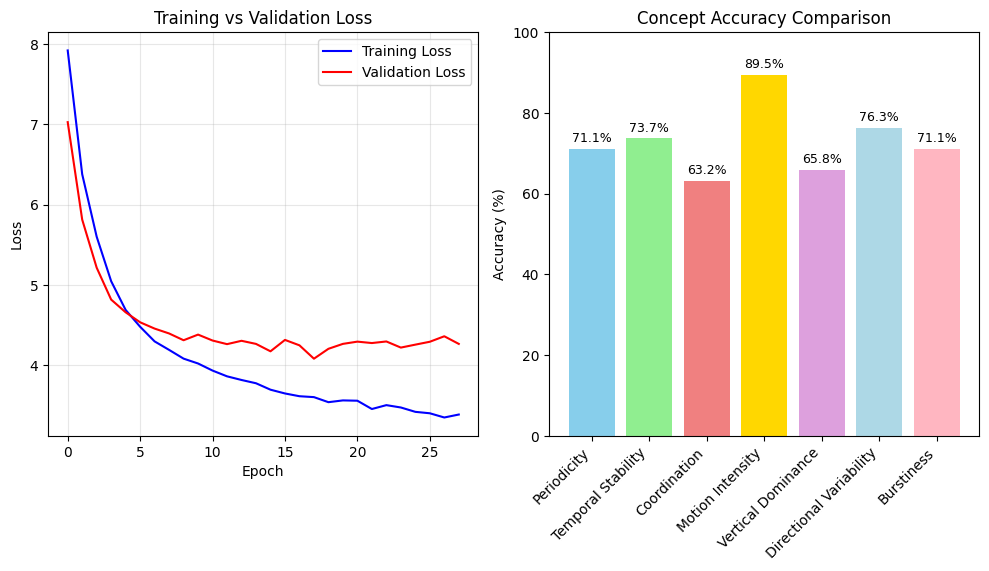

In [2922]:
# Training History Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Training and Validation Loss
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Overall Accuracy Comparison
plt.subplot(2, 3, 2)
concepts = ['Periodicity', 'Temporal Stability', 'Coordination', 'Motion Intensity', 
           'Vertical Dominance', 'Directional Variability', 'Burstiness']
accuracies = [periodicity_acc*100, temporal_stability_acc*100, coordination_acc*100, 
              motion_intensity_acc*100, vertical_dominance_acc*100, 
              directional_variability_acc*100, burstiness_acc*100]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum', 'lightblue', 'lightpink']

bars = plt.bar(concepts, accuracies, color=colors)
plt.title('Concept Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


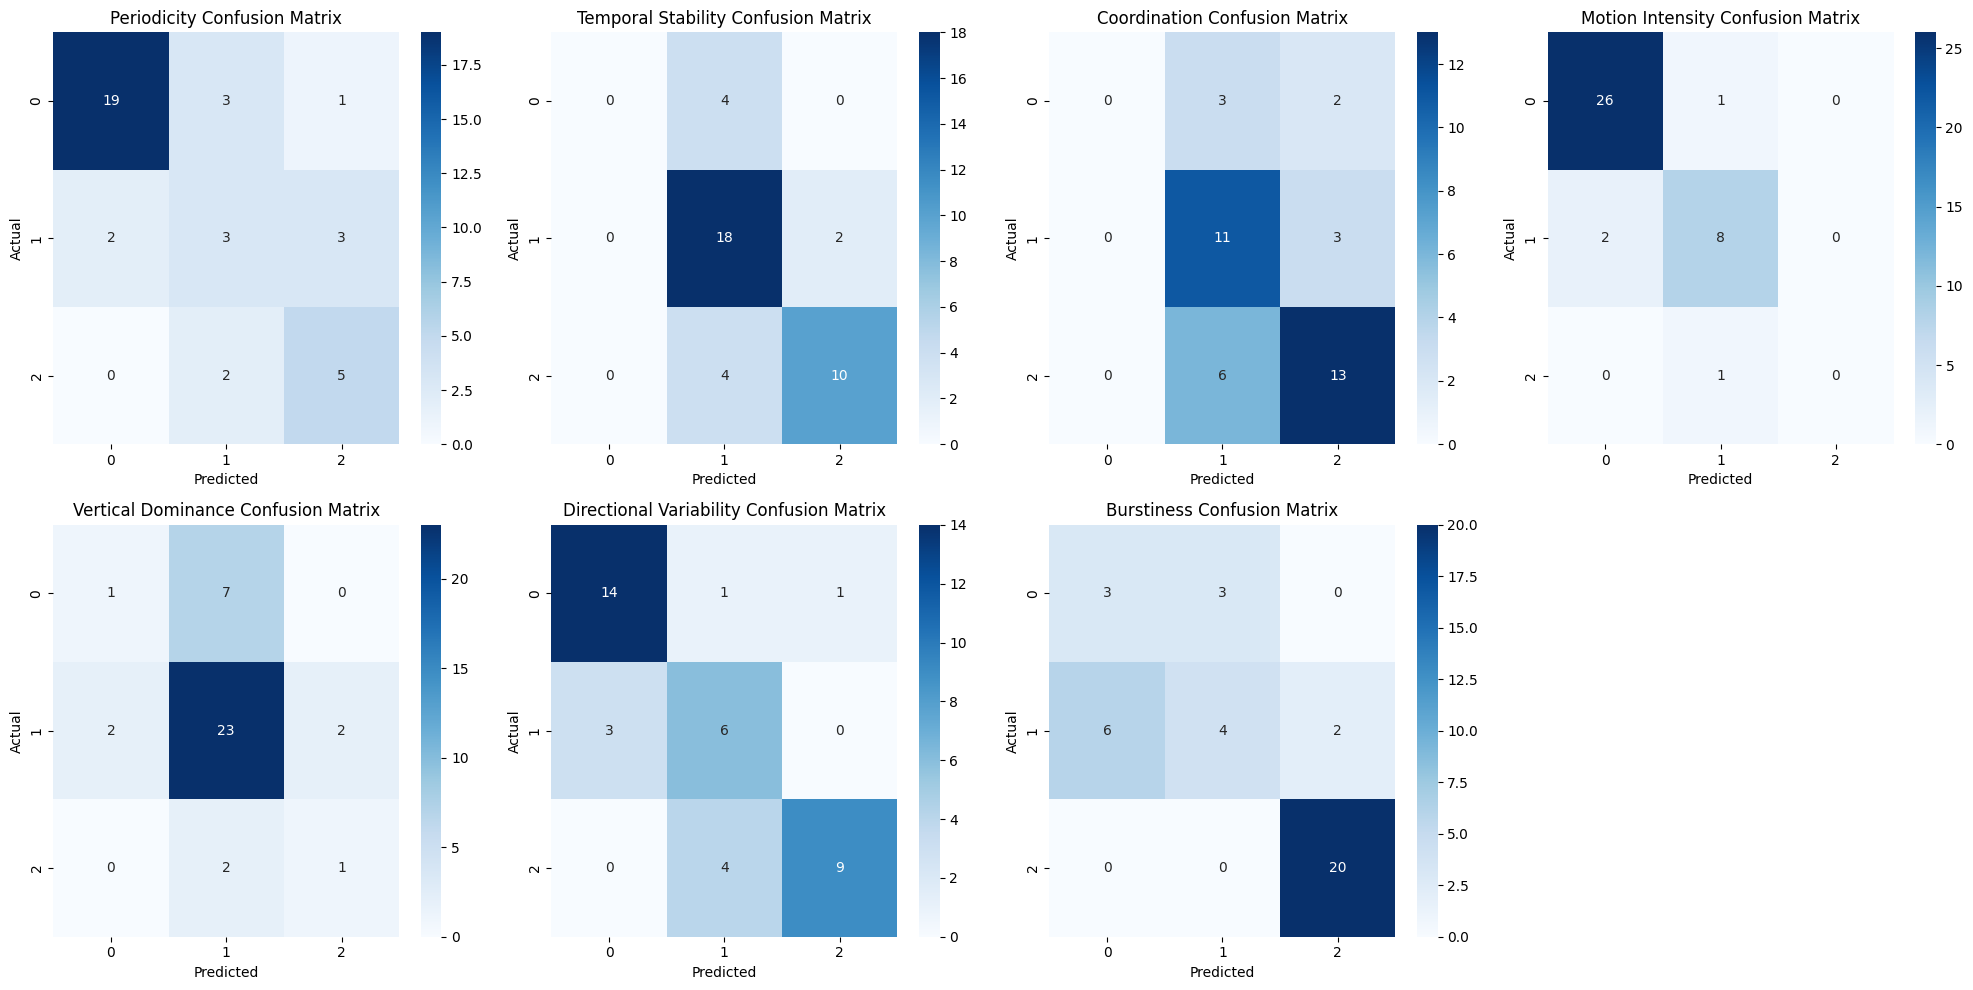

In [2923]:
# Confusion Matrices for Each Concept
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

concept_data = [
    ('Periodicity', periodicity_true, periodicity_pred),
    ('Temporal Stability', temporal_stability_true, temporal_stability_pred),
    ('Coordination', coordination_true, coordination_pred),
    ('Motion Intensity', motion_intensity_true, motion_intensity_pred),
    ('Vertical Dominance', vertical_dominance_true, vertical_dominance_pred),
    ('Directional Variability', directional_variability_true, directional_variability_pred),
    ('Burstiness', burstiness_true, burstiness_pred)
]

for i, (name, y_true, y_pred) in enumerate(concept_data):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Hide the last subplot if not needed
if len(concept_data) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()


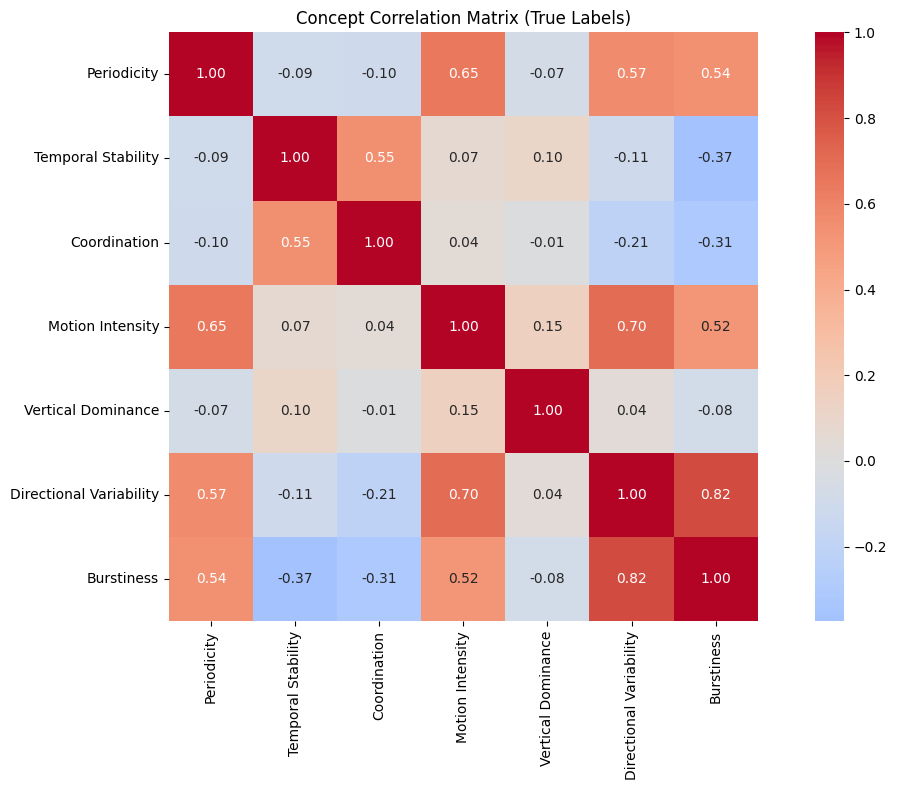

=== CONCEPT CORRELATION INSIGHTS ===
High correlations (>0.5) indicate potential redundancy:
Periodicity ↔ Motion Intensity: 0.652
Periodicity ↔ Directional Variability: 0.570
Periodicity ↔ Burstiness: 0.540
Temporal Stability ↔ Coordination: 0.547
Motion Intensity ↔ Directional Variability: 0.697
Motion Intensity ↔ Burstiness: 0.520
Directional Variability ↔ Burstiness: 0.821


In [2924]:
# Concept Correlation Analysis
plt.figure(figsize=(12, 8))

# Create correlation matrix of true labels
concept_labels = np.column_stack([
    periodicity_true, temporal_stability_true, coordination_true,
    motion_intensity_true, vertical_dominance_true, 
    directional_variability_true, burstiness_true
])

correlation_matrix = np.corrcoef(concept_labels.T)

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            xticklabels=concepts,
            yticklabels=concepts,
            fmt='.2f')

plt.title('Concept Correlation Matrix (True Labels)')
plt.tight_layout()
plt.show()

# Print correlation insights
print("=== CONCEPT CORRELATION INSIGHTS ===")
print("High correlations (>0.5) indicate potential redundancy:")
for i in range(len(concepts)):
    for j in range(i+1, len(concepts)):
        corr = correlation_matrix[i, j]
        if abs(corr) > 0.5:
            print(f"{concepts[i]} ↔ {concepts[j]}: {corr:.3f}")


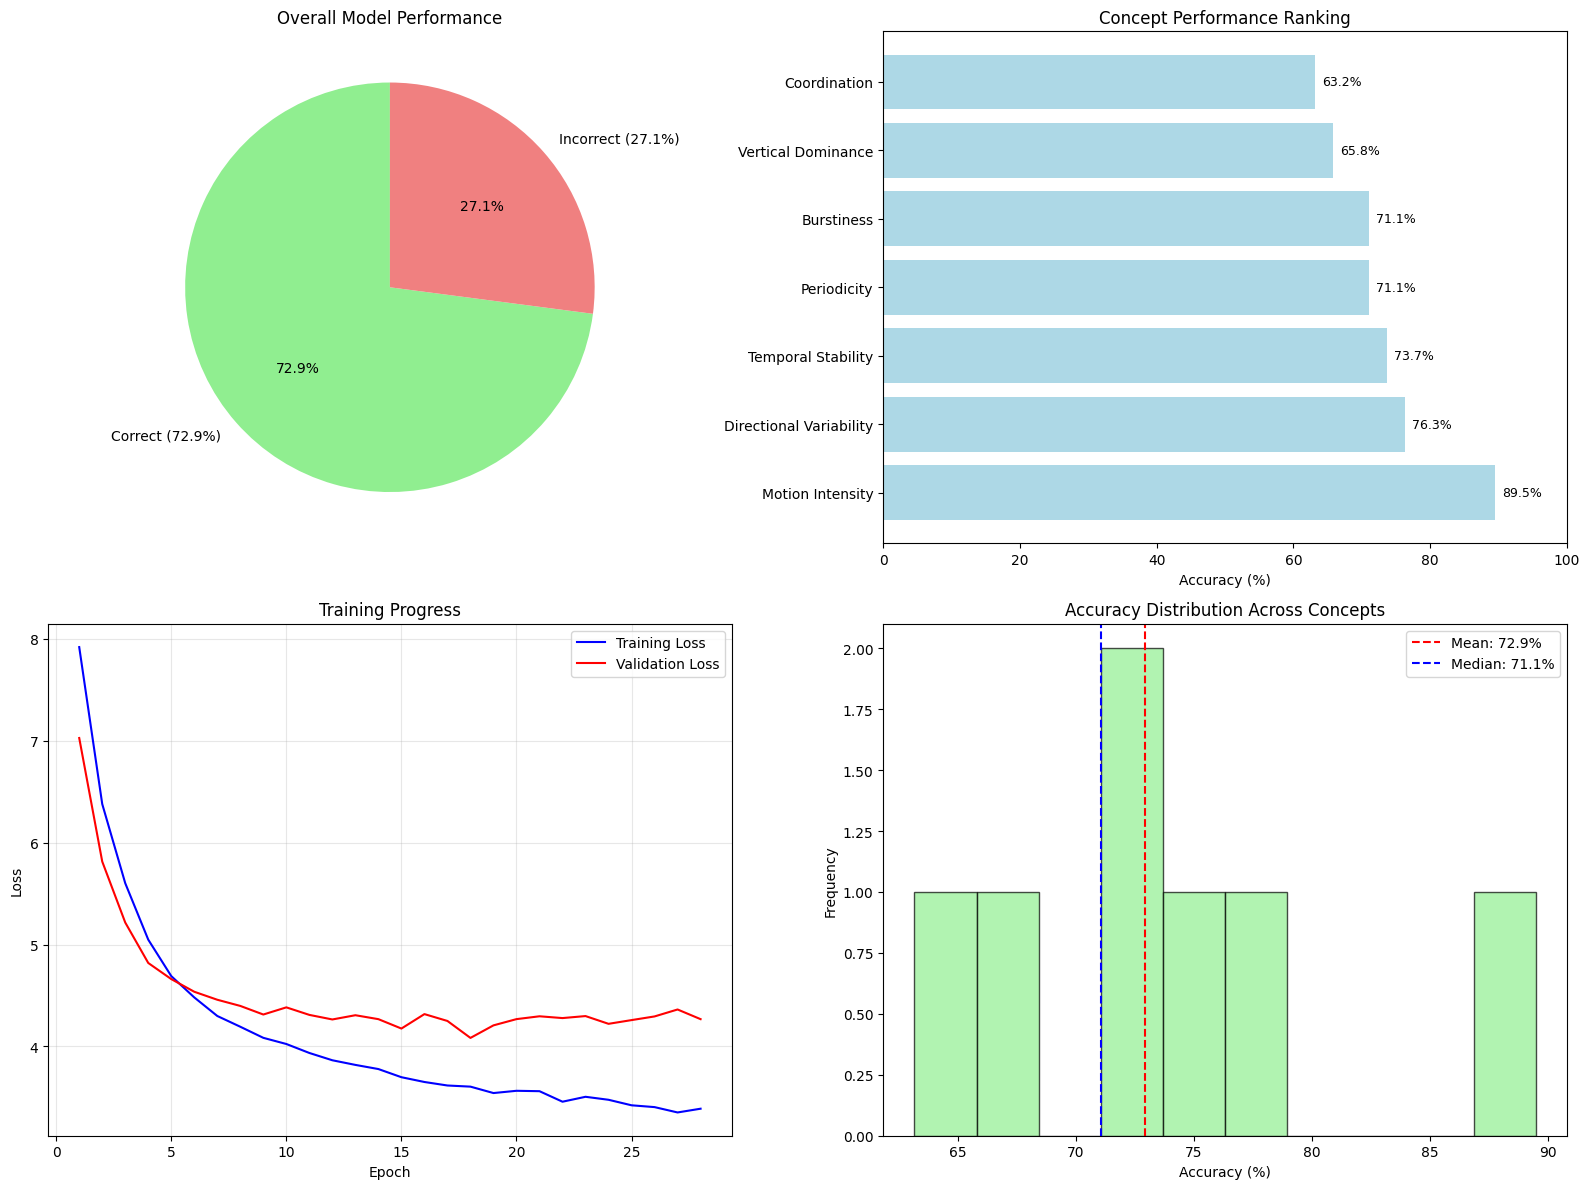


=== PERFORMANCE SUMMARY ===
Overall Accuracy: 72.9%
Best Performing Concept: Motion Intensity (89.5%)
Worst Performing Concept: Coordination (63.2%)
Performance Range: 63.2% - 89.5%
Standard Deviation: 7.9%


In [2925]:
# Performance Summary Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall Performance Summary
ax1.pie([overall_acc*100, 100-overall_acc*100], 
        labels=[f'Correct ({overall_acc*100:.1f}%)', f'Incorrect ({100-overall_acc*100:.1f}%)'],
        colors=['lightgreen', 'lightcoral'], autopct='%1.1f%%', startangle=90)
ax1.set_title('Overall Model Performance')

# 2. Concept Performance Ranking
sorted_concepts = sorted(zip(concepts, accuracies), key=lambda x: x[1], reverse=True)
sorted_names, sorted_accs = zip(*sorted_concepts)

bars = ax2.barh(range(len(sorted_names)), sorted_accs, color='lightblue')
ax2.set_yticks(range(len(sorted_names)))
ax2.set_yticklabels(sorted_names)
ax2.set_xlabel('Accuracy (%)')
ax2.set_title('Concept Performance Ranking')
ax2.set_xlim(0, 100)

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, sorted_accs)):
    ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f'{acc:.1f}%', va='center', fontsize=9)

# 3. Training Progress (if available)
if 'loss' in history.history:
    epochs = range(1, len(history.history['loss']) + 1)
    ax3.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    if 'val_loss' in history.history:
        ax3.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    ax3.set_title('Training Progress')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Performance Distribution
ax4.hist(accuracies, bins=10, color='lightgreen', alpha=0.7, edgecolor='black')
ax4.axvline(np.mean(accuracies), color='red', linestyle='--', 
           label=f'Mean: {np.mean(accuracies):.1f}%')
ax4.axvline(np.median(accuracies), color='blue', linestyle='--', 
           label=f'Median: {np.median(accuracies):.1f}%')
ax4.set_title('Accuracy Distribution Across Concepts')
ax4.set_xlabel('Accuracy (%)')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.show()

# Print performance summary
print(f"\n=== PERFORMANCE SUMMARY ===")
print(f"Overall Accuracy: {overall_acc*100:.1f}%")
print(f"Best Performing Concept: {sorted_names[0]} ({sorted_accs[0]:.1f}%)")
print(f"Worst Performing Concept: {sorted_names[-1]} ({sorted_accs[-1]:.1f}%)")
print(f"Performance Range: {sorted_accs[-1]:.1f}% - {sorted_accs[0]:.1f}%")
print(f"Standard Deviation: {np.std(accuracies):.1f}%")
